<a href="https://colab.research.google.com/github/pharringtonp19/business-analytics/blob/main/notebooks/regression/regression_transformations_motivation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/pharringtonp19/business-analytics.git

Cloning into 'business-analytics'...
remote: Enumerating objects: 1355, done.
remote: Counting objects: 100% (410/410), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 1355 (delta 359), reused 254 (delta 254), pack-reused 945 (from 1)
Receiving objects: 100% (1355/1355), 22.96 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (815/815), done.


### **Import Packages**

In [12]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import jax.numpy as jnp
import jax
import seaborn as sb
from functools import partial
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### **Transformations**

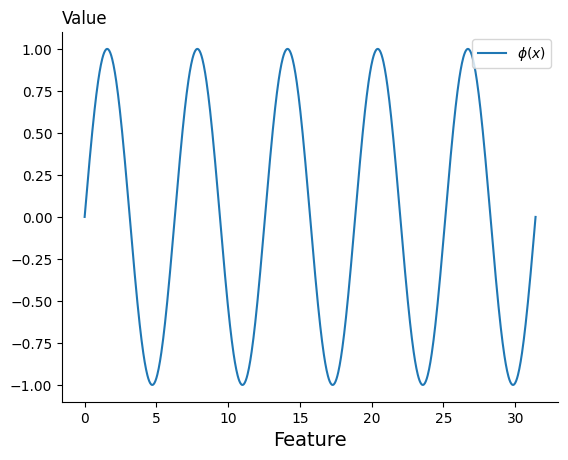

In [15]:
xs = jnp.linspace(0, 10*math.pi, 1000)
ys = jnp.sin(xs)
plt.plot(xs, ys, label=r'$\phi(x)$')
plt.title('Value', loc='left')
plt.xlabel('Feature', size=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.show()

### **Read In Data Set**

In [3]:
df = pd.read_csv('/content/business-analytics/datasets/AirPassengers.csv')
df.columns = ['Month', 'Passengers']
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
# Convert 'Month' to datetime if not already
df['Month_numeric'] = pd.to_datetime(df['Month'])

# Calculate the number of months since the first date
df['Month_Encoded'] = (df['Month_numeric'] - df['Month_numeric'].min()).dt.days // 30

# Min-Max Scaling

df['Month_Encoded_Scaled'] = (df['Month_Encoded'] - df['Month_Encoded'].min()) / (df['Month_Encoded'].max() - df['Month_Encoded'].min())

### **Plot**

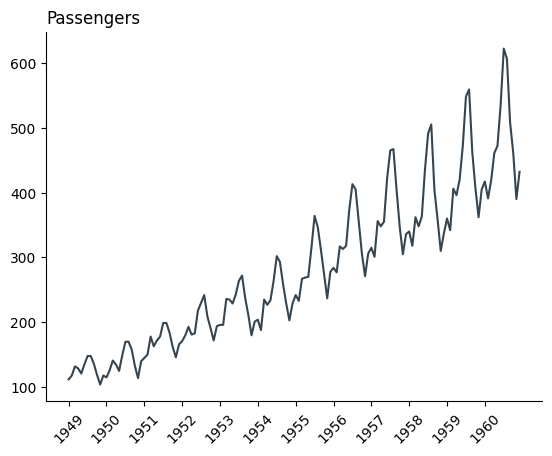

In [5]:
plt.plot(df['Month'], df['Passengers'], color="#36454F")
plt.title('Passengers', loc='left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Select ticks and labels for the x-axis (every 12th month, assuming monthly data)
tick_positions = df.index[::12]  # Use the index for positioning
tick_labels = df['Month'][::12].str.split('-').str[0]  # Extract only the year part

# Set ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)  # Rotate for better readability

# Show the plot
plt.show()

In [6]:
def gen_polynomial(k):
    def applyk(x):
        return x**k
    applyk.__name__ = f"x_{k}"
    return applyk

## **Helper Functions**

In [7]:
def apply_transformations(df, variable, list_of_transformations):
  """Treat this as a function defined in another package"""

  # Transformation function
  def transformations(column_name, f):
      return f.__name__, df[column_name].map(f)

  # Apply transformations
  results = list(map(partial(transformations, variable), list_of_transformations))

  # Convert results to a DataFrame with appropriate column names
  transformed_df = pd.DataFrame({key: value for key, value in results})

  # Concatenate original DataFrame with the transformed DataFrame
  df = pd.concat([df, transformed_df], axis=1)

  # Transformed Variable Names
  transformed_variable_names, transformed_columns = zip(*results)
  return df, transformed_variable_names


def create_regression_string(dep_var, transformed_variables):
  if len(transformed_variables) == 1:
    return f'{dep_var} ~ {transformed_variables[0]}'
  return f'{dep_var} ~ {transformed_variables[0] + " + " + " + ".join(transformed_variables[1:])}'

### **Apply Transformations**

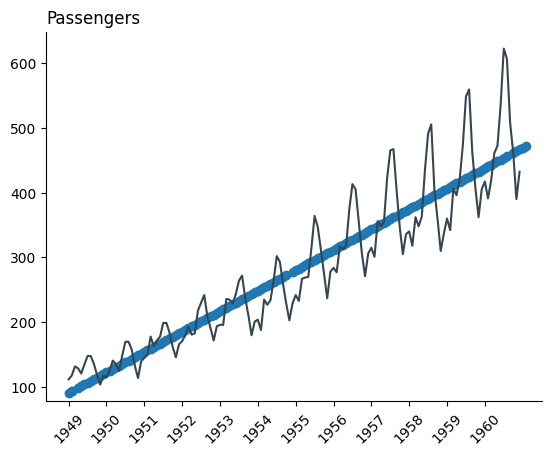

In [11]:
transformations = list(map(gen_polynomial, range(2)))
new_df, transformed_variables = apply_transformations(df, 'Month_Encoded_Scaled', transformations)
regression_string = create_regression_string('Passengers', transformed_variables)
linear_model = smf.ols(regression_string, data=new_df)
results = linear_model.fit()
yhat = results.fittedvalues
plt.scatter(df['Month_Encoded'], yhat)
plt.plot(df['Month'], df['Passengers'], color="#36454F")
plt.title('Passengers', loc='left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Select ticks and labels for the x-axis (every 12th month, assuming monthly data)
tick_positions = df.index[::12]  # Use the index for positioning
tick_labels = df['Month'][::12].str.split('-').str[0]  # Extract only the year part

# Set ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)  # Rotate for better readability

# Show the plot
plt.show()

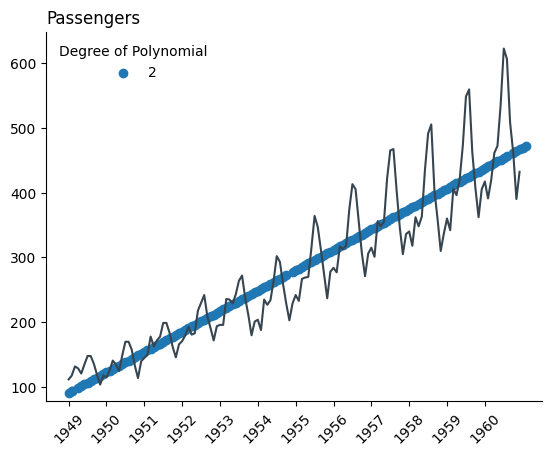

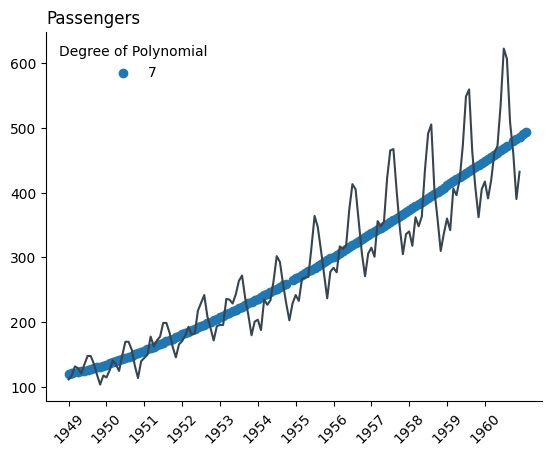

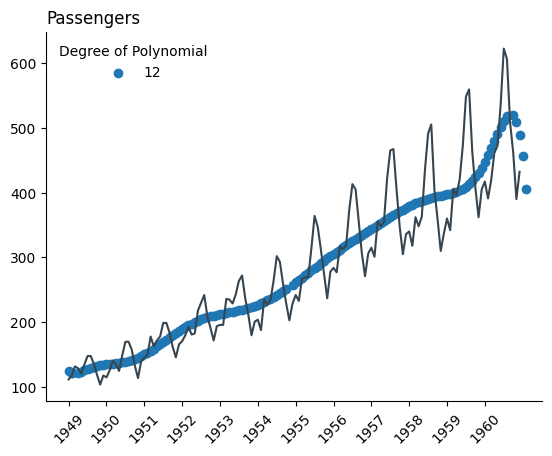

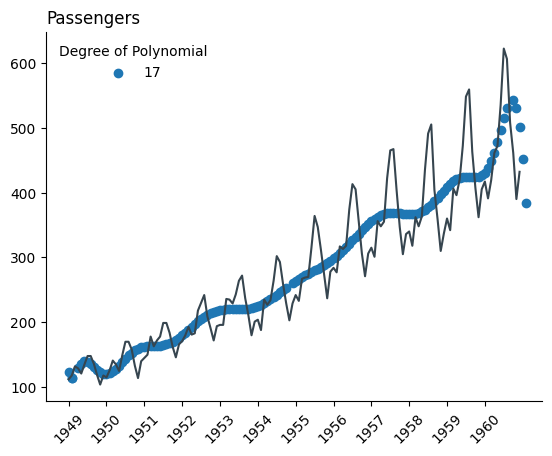

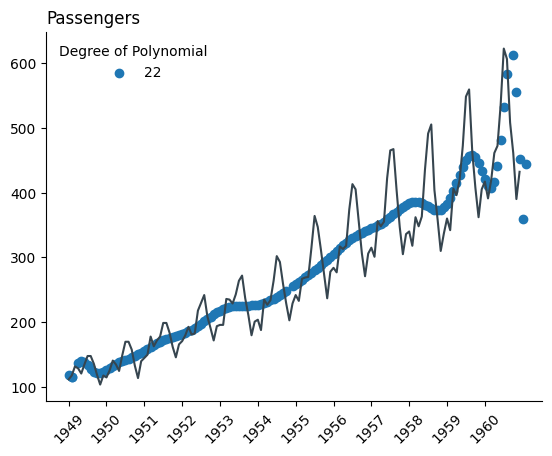

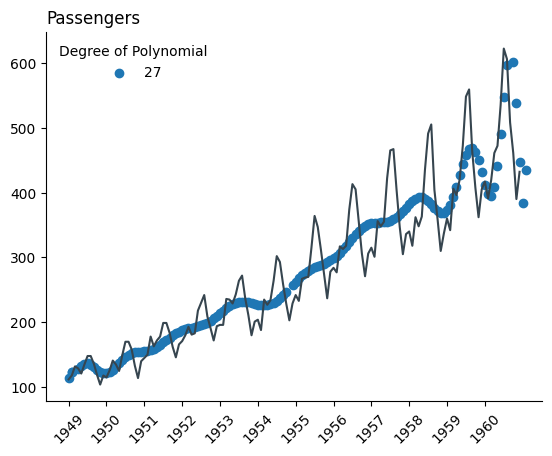

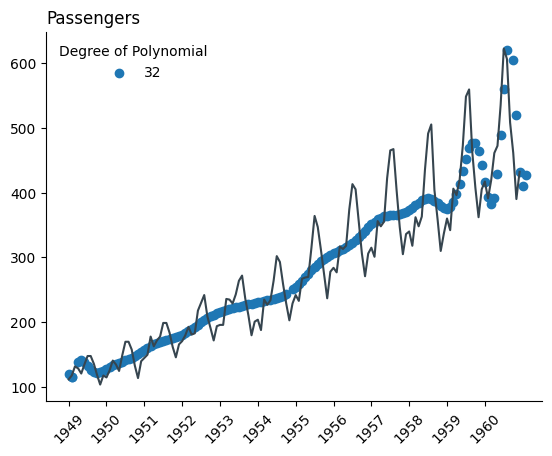

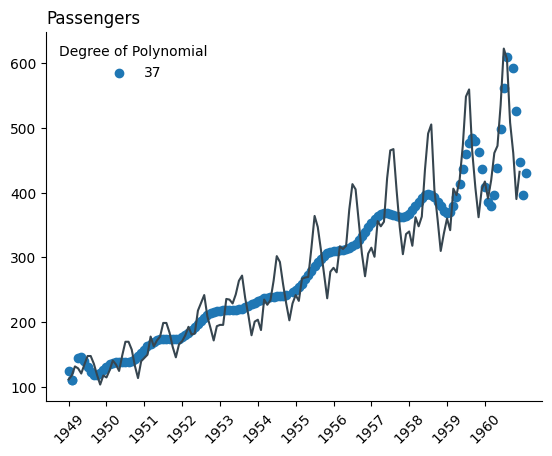

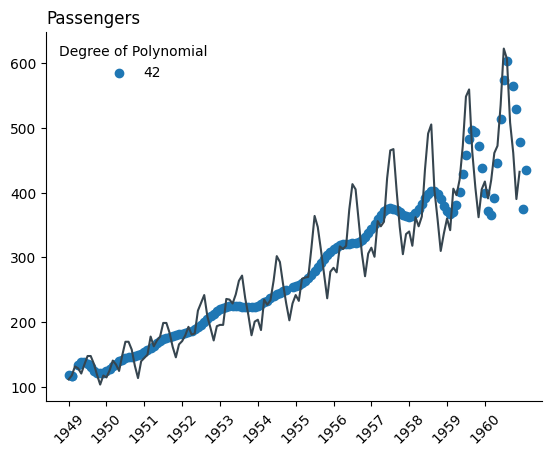

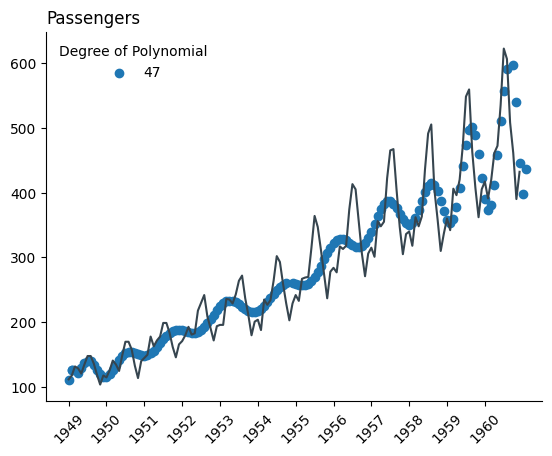

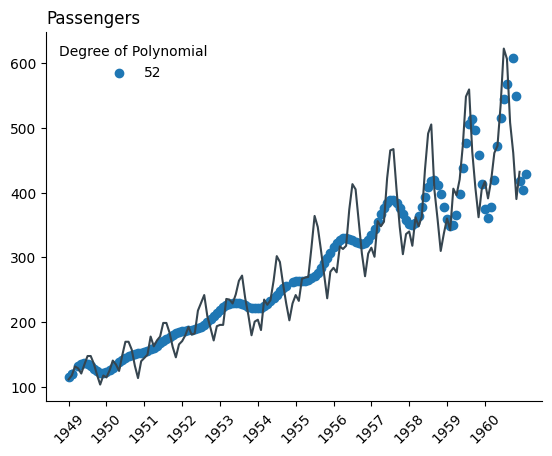

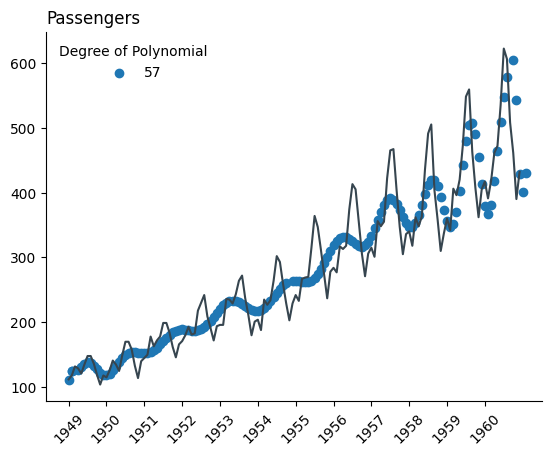

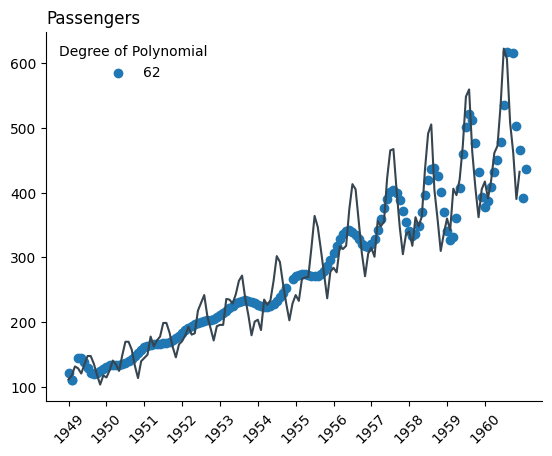

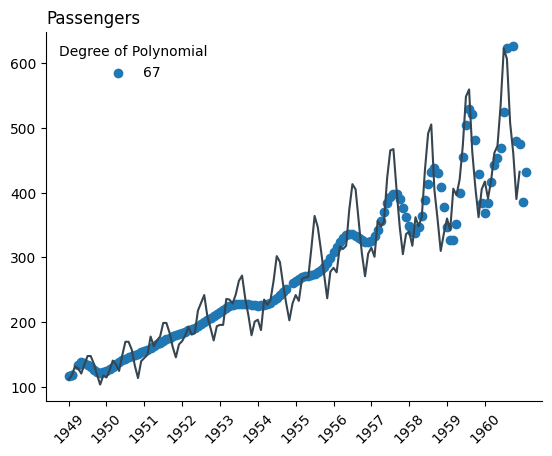

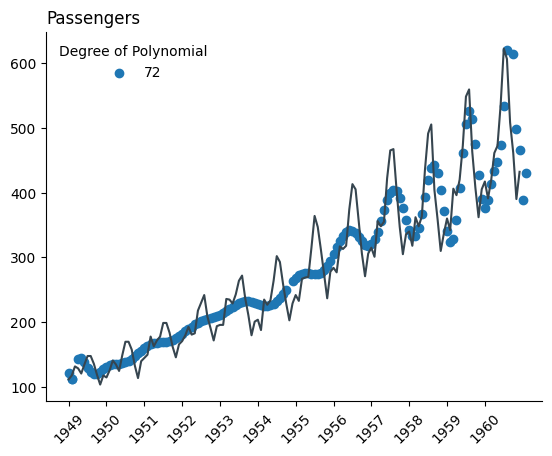

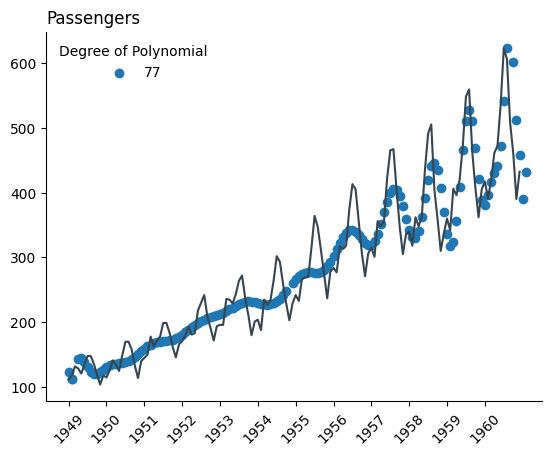

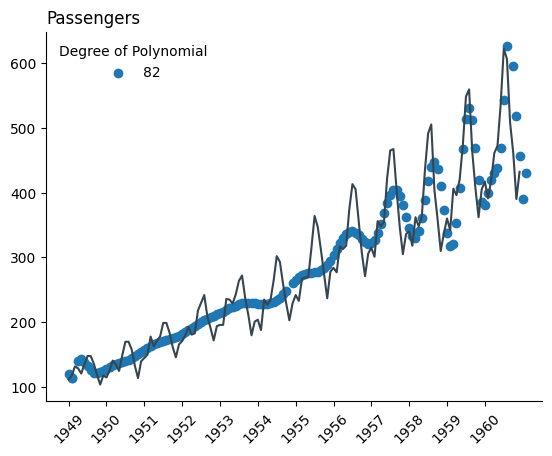

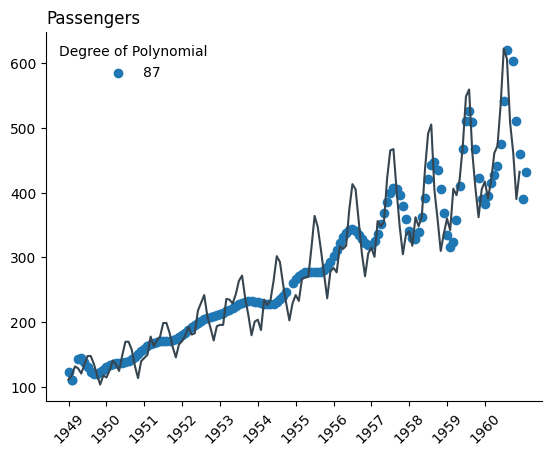

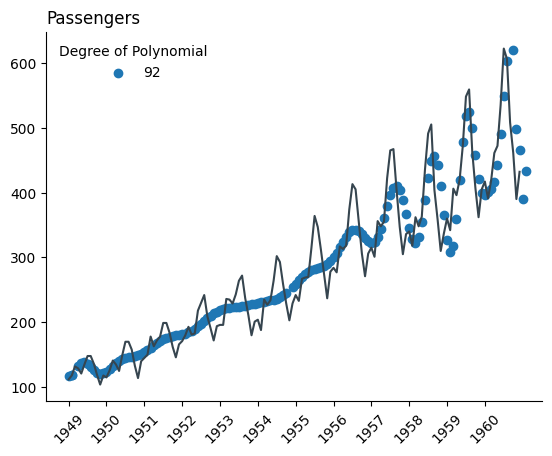

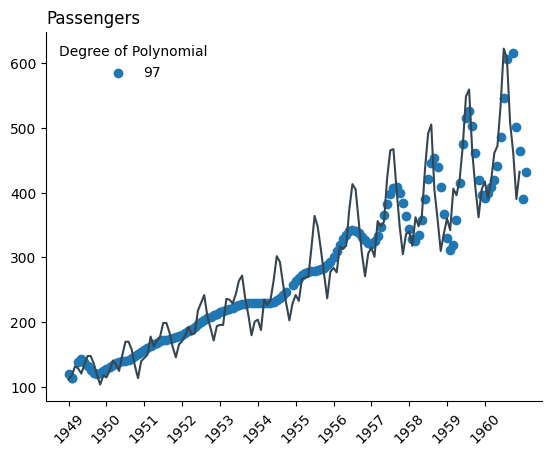

In [9]:
mses = []
Range = range(2, 100, 5)
for i in Range:
  transformations = list(map(gen_polynomial, range(i)))
  new_df, transformed_variables = apply_transformations(df, 'Month_Encoded_Scaled', transformations)
  regression_string = create_regression_string('Passengers', transformed_variables)
  linear_model = smf.ols(regression_string, data=new_df)
  results = linear_model.fit()
  mse = (results.resid**2).mean()
  mses.append(mse)
  yhat = results.fittedvalues

  plt.scatter(df['Month_Encoded'], yhat, label=i)
  plt.plot(df['Month'], df['Passengers'], color="#36454F")
  plt.title('Passengers', loc='left')
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # Select ticks and labels for the x-axis (every 12th month, assuming monthly data)
  tick_positions = df.index[::12]  # Use the index for positioning
  tick_labels = df['Month'][::12].str.split('-').str[0]  # Extract only the year part

  # Set ticks and labels
  ax.set_xticks(tick_positions)
  ax.set_xticklabels(tick_labels, rotation=45)  # Rotate for better readability
  plt.legend(title='Degree of Polynomial', frameon=False)
  # Show the plot
  plt.show()

### **Mean Squared Error Plot**

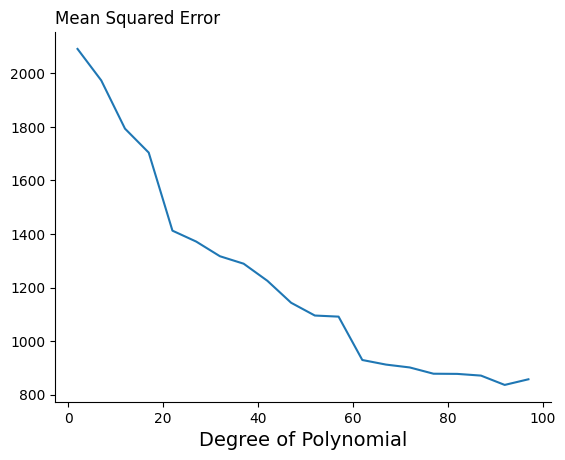

In [10]:
plt.plot(Range, mses)
plt.title('Mean Squared Error', loc='left')
plt.xlabel('Degree of Polynomial', size=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()